https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking_python3.ipynb

In [1]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from nltk import word_tokenize
from fastText import load_model

FT_MODEL = "wiki.simple.bin"
encoding="utf-8"

/data/joydeep/pytorchfasttext/vevn/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def ingest():
    data = pd.read_csv('./yelp_review.csv')
    data = data[data['text'].isnull() == False]
    data = data[data['stars'].isnull() == False]
    data['stars'] = data['stars'].map(int)
    data = data[['text', 'stars']]
    print ('dataset loaded with shape', data.shape)    
    return data

data = ingest()
data.head(5)

dataset loaded with shape (5261668, 2)


,text,stars
0,Super simple place but amazing nonetheless. It...,5
1,Small unassuming place that changes their menu...,5
2,Lester's is located in a beautiful neighborhoo...,5
3,Love coming here. Yes the place always needs t...,4
4,Had their chocolate almond croissant and it wa...,4


In [3]:
def tokenize(comment):
    """If comment present then tokenise the comment using nltk else return no comment."""
    try:
        comment = comment.lower()
        tokens = word_tokenize(comment)
        return list(tokens)
    except:
        return 'NC'
    
tokenize("I don't like this restaurant.\n lets go somewhere else.")

['i',
 'do',
 "n't",
 'like',
 'this',
 'restaurant',
 '.',
 'lets',
 'go',
 'somewhere',
 'else',
 '.']

In [4]:
def postprocess(data, n=-1):
    if n != -1:
        data = data.head(n)
    data['tokens'] = data['text'].apply(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
#     data.reset_index(inplace=True)
#     data.drop('index', inplace=True, axis=1)
    return data

data = postprocess(data, 10000)
data.head()

/data/joydeep/pytorchfasttext/vevn/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,text,stars,tokens
0,Super simple place but amazing nonetheless. It...,5,"[super, simple, place, but, amazing, nonethele..."
1,Small unassuming place that changes their menu...,5,"[small, unassuming, place, that, changes, thei..."
2,Lester's is located in a beautiful neighborhoo...,5,"[lester, 's, is, located, in, a, beautiful, ne..."
3,Love coming here. Yes the place always needs t...,4,"[love, coming, here, ., yes, the, place, alway..."
4,Had their chocolate almond croissant and it wa...,4,"[had, their, chocolate, almond, croissant, and..."


In [5]:
f = load_model(FT_MODEL)

all_words = set([x for tokens in data['tokens'].values for x in tokens])

wv_dictionary = {w: f.get_word_vector(w) for w in all_words}

In [6]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, ft_wv):
        self.ft_wv = ft_wv
        if len(ft_wv)>0:
            self.dim = ft_wv[next(iter(all_words))].shape[0] 
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.ft_wv[w] for w in words if w in self.ft_wv] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, ft_wv):
        self.ft_wv = ft_wv
        self.word2weight = None
        if len(ft_wv) > 0:
            self.dim = ft_wv[next(iter(all_words))].shape[0]
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.ft_wv[w] * self.word2weight[w]
                         for w in words if w in self.ft_wv] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [7]:
etree_w2v = Pipeline([("fasttext word-vector vectorizer", MeanEmbeddingVectorizer(wv_dictionary)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [8]:
all_models = [
    ("w2v", etree_w2v),
]

In [9]:
X, y = data['tokens'], data['stars']

In [10]:
def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [11]:
unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))


train_sizes = [100, 400, 1600, 3200, 6400, 8000]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)

model      score
-------  -------
w2v       0.4403


[Text(0,0.5,'accuracy')]

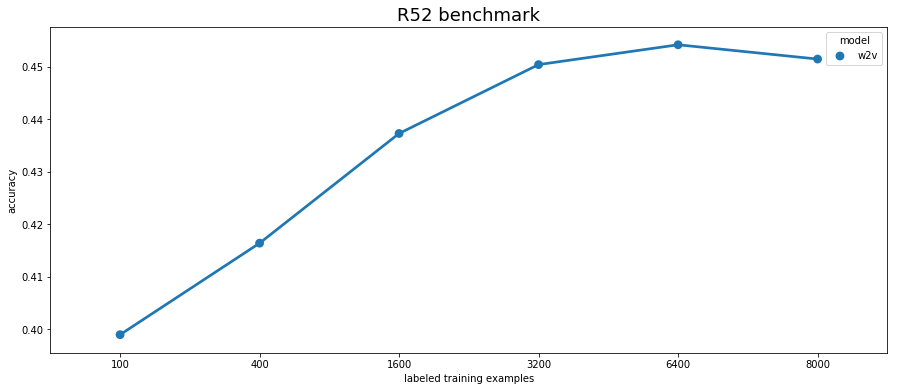

In [12]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["w2v"])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R52 benchmark")
fig.set(ylabel="accuracy")